# Throwing the data at some ML models to see what happens 

In [1]:
import json
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfqc.network as nw
from scipy.stats import ttest_rel, spearmanr
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import tree
from wfqc.metrics import *
from datetime import datetime

Two approaches are shown here, the old one is using the raw edge weights as input to some ML models, whereas the new one is creating a feature vector from each workflow

### Loading data

In [3]:
with open('../out_202407041439/train_rated.json', 'r') as f:
    rated_workflows = json.load(f)

In [4]:
with open('../out_202407041439/edgestopic_0121.json', 'r') as f:
    citation_data = json.load(f)

citation_counts = {tool['pmid']: tool['nr_citations'] for tool in citation_data['tools']}

In [5]:
with open('../../tool_metadata_topic_0121_20240703.json', "r") as f: # as generated by create_network
    metadata_file = json.load(f)

tool_ages = {tool['pmid']:tool['publication_date'] for tool in metadata_file['tools']}

In [6]:
graph = nw.create_network(inpath='../out_202407041439')


Loading saved data.


# Converting workflows to feature vectors

In [ ]:
"""

Proposed structure: list of features


"""

In [7]:
def convert_to_tuples(list_of_lists):
    """
    Converts a list of lists into a list of tuples.

    :param list_of_lists: List of lists to be converted.
    :return: List of tuples.
    """
    return [tuple(inner_list) for inner_list in list_of_lists]



In [8]:
def nr_tools(workflow, include_none = False): # this is incorrect, since a tool be used repeatedly, btu I dont know how tpo take that ointo accoutn right now 
    tools = set()
    if include_none:
        tools = {pmid for tup in workflow for pmid in tup if pmid is not None}
        return tools 
    else:
        tools = list({pmid for tup in workflow for pmid in tup})
        return tools

In [9]:
def not_none_workflows(workflows, type_ = dict):
    notnone_workflows = []
    
    if type_ == list:
        for workflow in workflows:
            tools = {pmid for tup in workflow for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows
    elif type_ == dict: 
        print("Assuming dictionary follows citation data file format.") # maybe spec what that is 
        for workflow in workflows:
            tools = {pmid for tup in convert_to_tuples(workflow['pmid_workflow']) for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows

In [10]:
def extract_workflow_features(workflow, graph, tool_citation_counts, tool_ages, tool_degrees):
    features =  np.zeros(12) 

    unique_tools = list({pmid for tup in workflow for pmid in tup})

    if not unique_tools:
        return features
    
    #metrics

    features[0] = sum_metric(graph, workflow)
    features[1] = log_sum_metric(graph, workflow)
    features[2] = connectivity(graph, workflow)

    ## Aggregated features

    # distribution of degrees within workflow tools, should I also add weighted degrees? 
    degrees = [tool_degrees[t] for t in unique_tools if tool_degrees[t] ] # define tool degree
    features[3] = np.mean(degrees)
    features[4] = min(degrees)
    features[5] = max(degrees)

    
    # distribution of ages within workflow tools 
    ages = [tool_ages[t] for t in unique_tools if tool_ages[t]] # Get ages
    if ages:
        current_year = datetime.now().year
        ages = [current_year - int(a.split(' ')[0]) for a in ages]
        features[6] = np.mean(ages)
        features[7] = min(ages)
        features[8] = max(ages)

    # distribution of citation counts, is this important?
    citation_counts = [tool_citation_counts[t] for t in unique_tools if tool_citation_counts[t] ] # define tool degree
    if citation_counts:
        features[9] = np.mean(citation_counts)
        features[10] = min(citation_counts)
        features[11] = max(citation_counts)

    return features

In [11]:
def create_feature_dataset(workflow_dict, graph, citation_counts, tool_ages, tool_degrees):

    labels = np.zeros((len(workflow_dict)))  
    feature_dataset = list(np.zeros((len(workflow_dict)))) 


    for i, workflow in enumerate(workflow_dict): 
        labels[i] = workflow["ratingAvg"] 
        # Make matrix representation of the workflow (converted to tuples so it works with the metrics)
        feature_dataset[i] = extract_workflow_features( convert_to_tuples(workflow["pmid_workflow"]), graph, citation_counts, tool_ages, tool_degrees)

    return labels, feature_dataset


### Preparing data and generating dataset

In [12]:
graph_node_ids = get_node_ids(graph)
tool_degrees =  {id_[0]: graph.degree(id_[1]) for id_ in graph_node_ids.items()}

In [13]:
workflow_dict = not_none_workflows(rated_workflows)
print("Number of worklows that only contain tools that are present in the graph: ", len(workflow_dict))

Assuming dictionary follows citation data file format.
Number of worklows that only contain tools that are present in the graph:  217


In [14]:
labels, feature_dataset = create_feature_dataset(workflow_dict, graph, citation_counts, tool_ages, tool_degrees)
feature_names =['sum', 'logsum', 'connectivity', 'mean_age', 'max_age', 'min_age', 'mean_degree', 'max_degree', 'min_degree', 'mean_citation', 'max_citation', 'min_citation']

Printing one workflow to confirm it worked

In [15]:
print(labels[0], feature_dataset[0])

0.5 [ 704.            5.57255092  606.5         720.5         462.
 1428.           16.5          11.           22.         2055.75
  718.         3040.        ]


### Plotting the distribution of labels before and after splitting 

To get a somewhat equal distribution I did a binned stratified split using 3 bins

In [16]:
X = feature_dataset
y = labels

X = np.array(X)
y = np.array(y)

n_bins = 3
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_binned = kbins.fit_transform(y.reshape(-1, 1)).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)


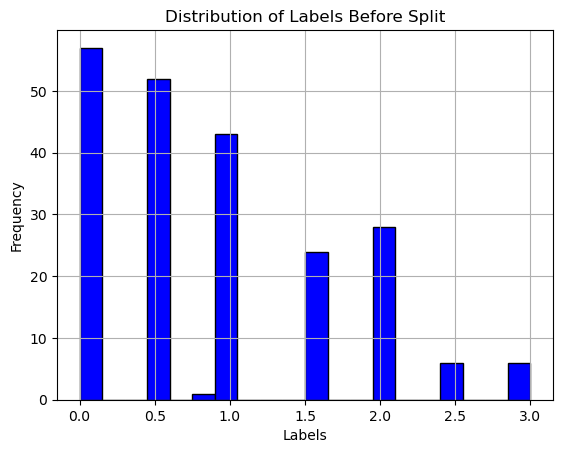

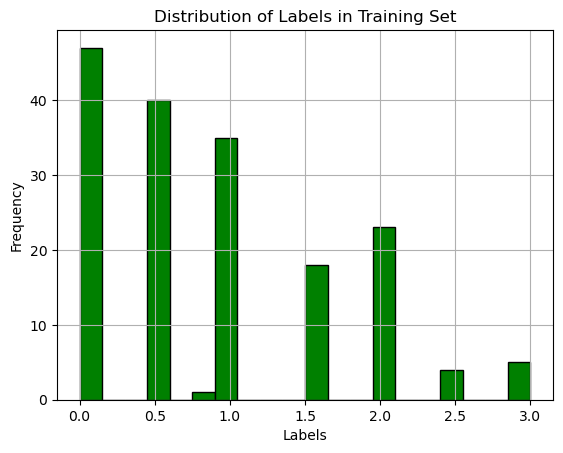

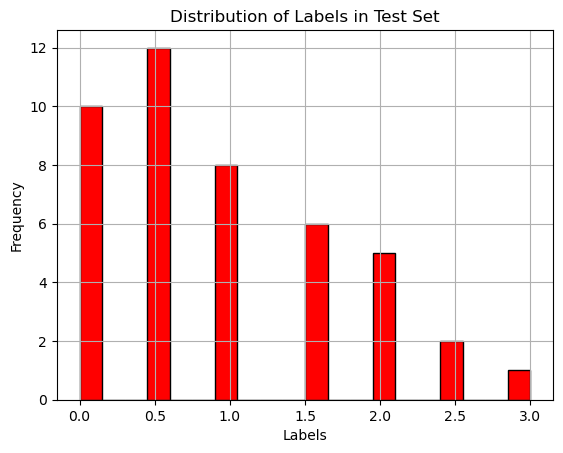

In [17]:
plt.hist(labels, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Labels Before Split')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#before split
plt.hist(y_train, bins=20, color='green', edgecolor='black')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# After
plt.hist(y_test, bins=20, color='red', edgecolor='black')
plt.title('Distribution of Labels in Test Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Training on the data
I want an interpretable model, which is as simple as possible to understand 

Mean Squared Error: 0.68


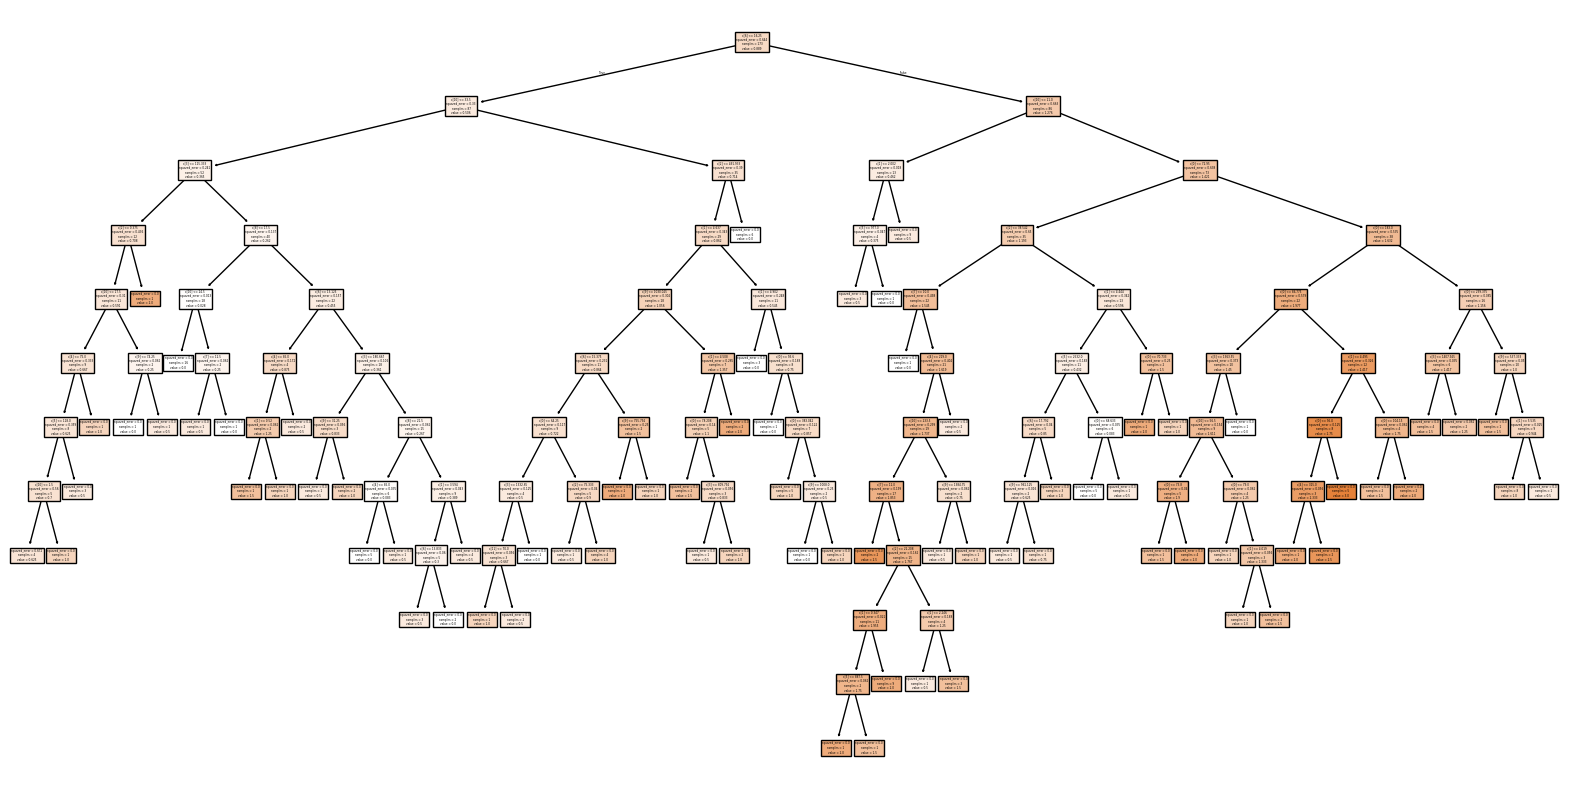

Spearman correlation coefficient between original and predicted ratings: 0.40


In [23]:
# Decision trees
model = DecisionTreeRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred) # idk if this is of value here with such an uneven split 
print(f'Mean Squared Error: {mse:.2f}')

plt.figure(figsize=(20, 10))
tree.plot_tree(model, filled=True)
plt.show()

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Mean Squared Error: 0.40


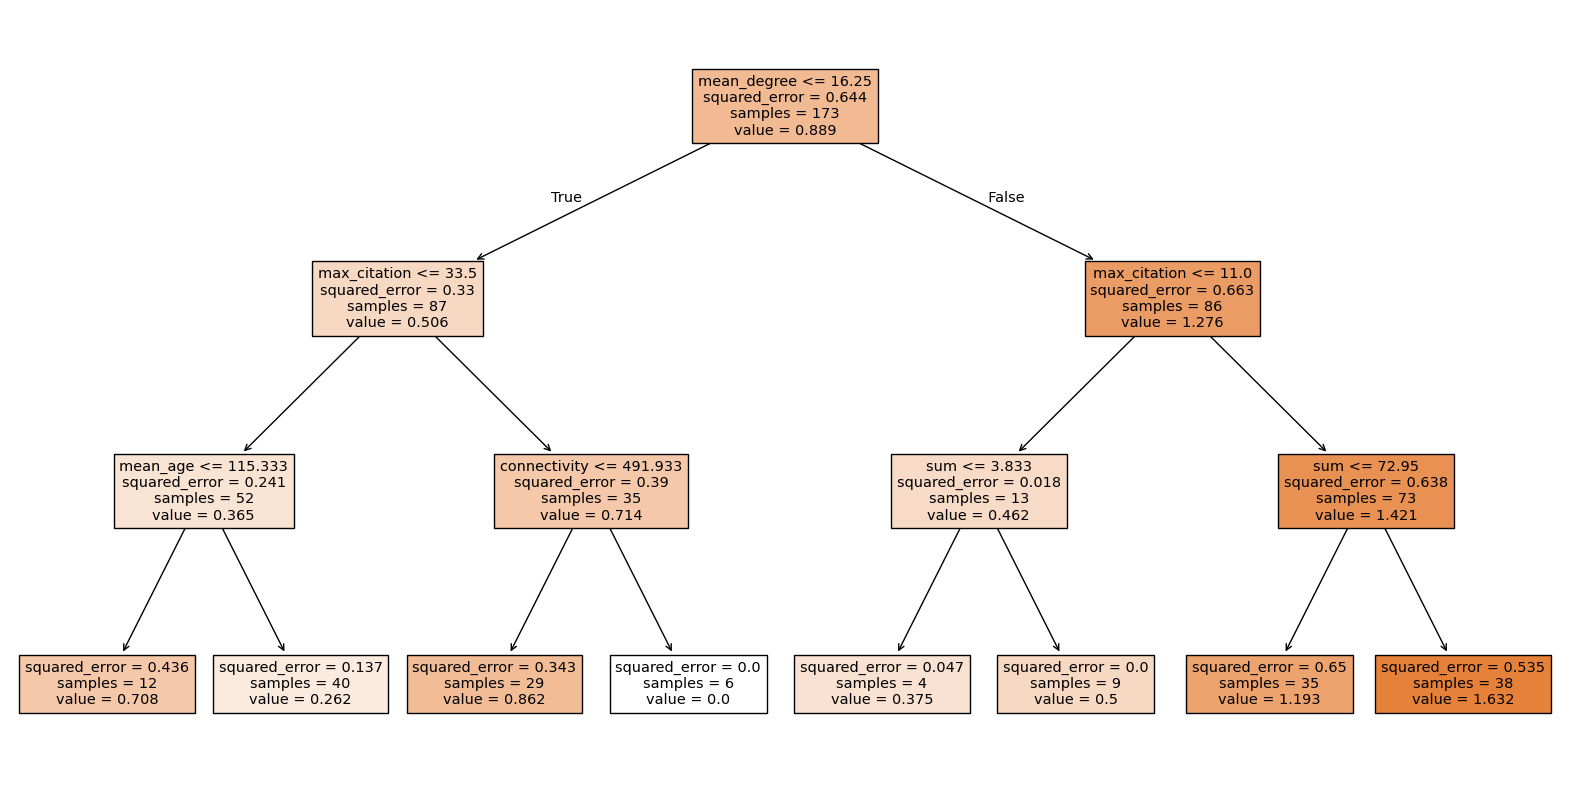

Spearman correlation coefficient between original and predicted ratings: 0.64


In [24]:
# Smaller decision tree

model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

from scipy.stats import spearmanr

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


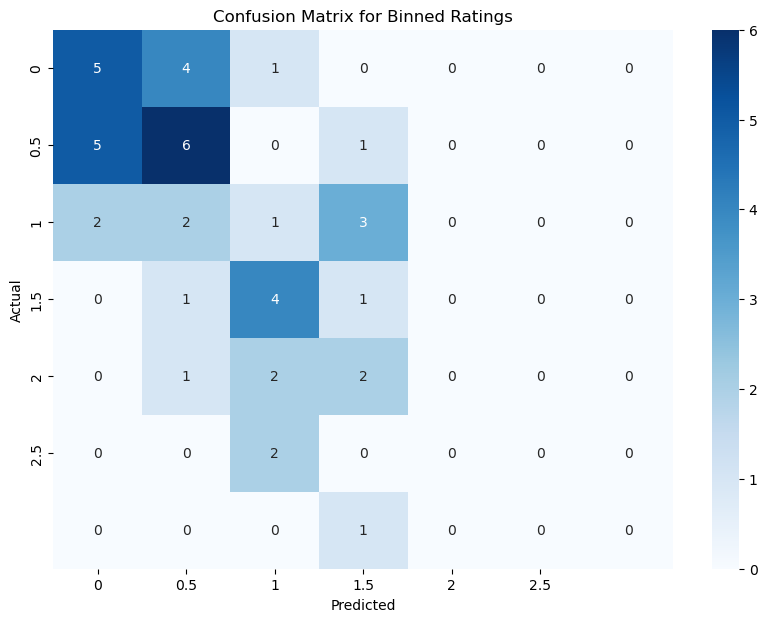

In [25]:
# Binned confusion matrix 
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3]
y_test_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred, bins) - 1

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=bins[:-1], yticklabels=bins[:-1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Binned Ratings')
plt.show()

None are predicted to be highest score despite having some 

In [26]:
correlation, _ = spearmanr(y_test, y_pred)
print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Spearman correlation coefficient between original and predicted ratings: 0.64


In [27]:
# Testing some other models 
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    correlation, _ = spearmanr(y_test, y_pred)
    return mse, correlation

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Support Vector Regressor": SVR()
}

results = {}
for name, model in models.items():
    mse, correlation = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {
        "Mean Squared Error": mse,
        "Pearson Correlation": correlation
    }

for name, metrics in results.items():
    print(f"{name}:\n - Mean Squared Error: {metrics['Mean Squared Error']:.2f}\n - Spearman Correlation: {metrics['Pearson Correlation']:.2f}\n")


Linear Regression:
 - Mean Squared Error: 0.48
 - Spearman Correlation: 0.49

Random Forest Regressor:
 - Mean Squared Error: 0.36
 - Spearman Correlation: 0.63

Support Vector Regressor:
 - Mean Squared Error: 0.47
 - Spearman Correlation: 0.57



Random forest has highest correlation, lets look at what features are most important to it

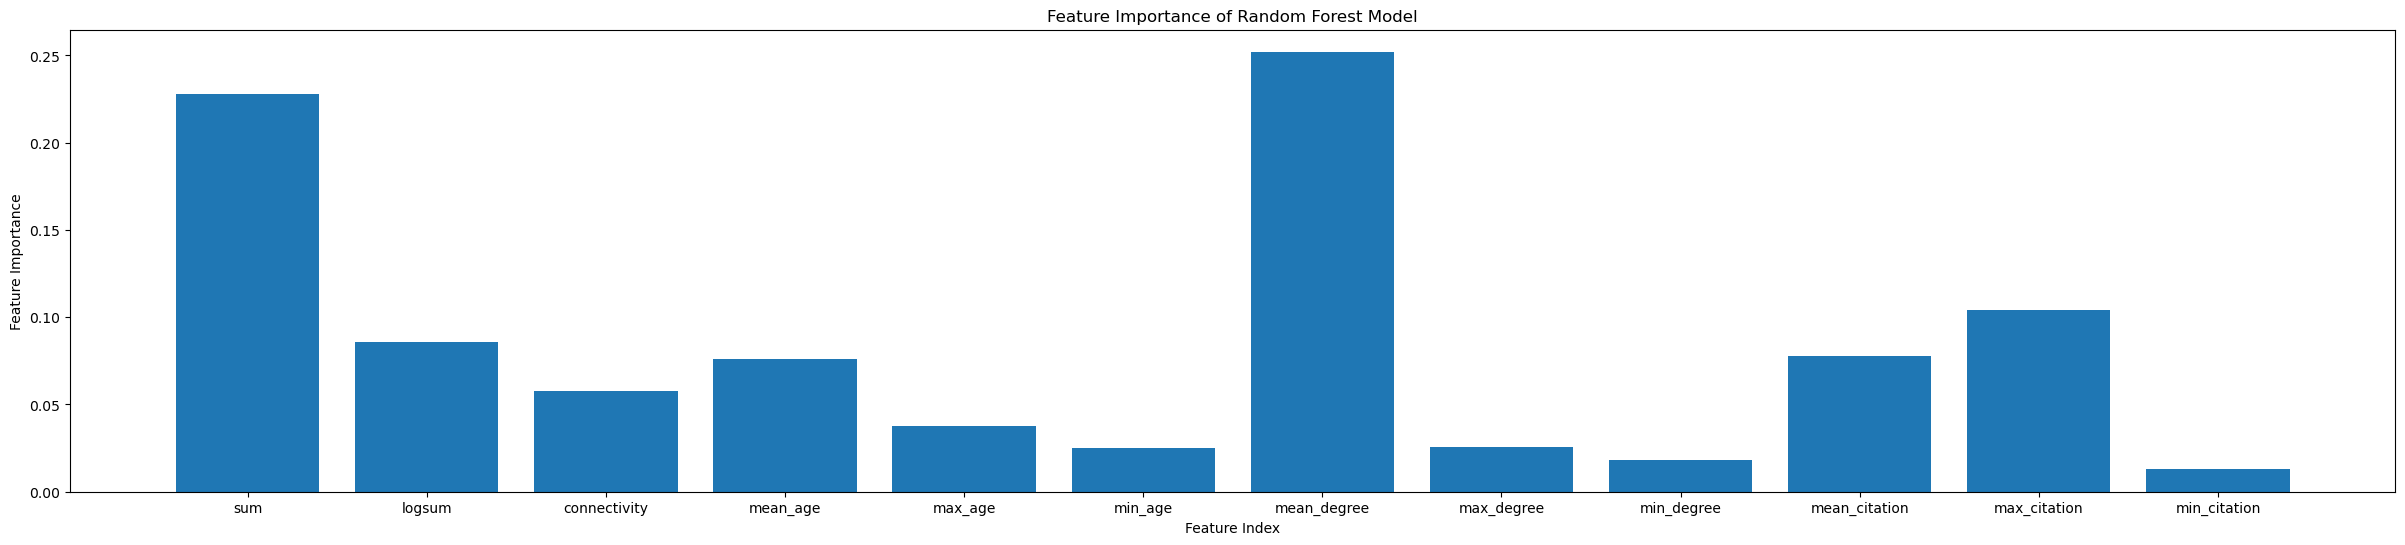

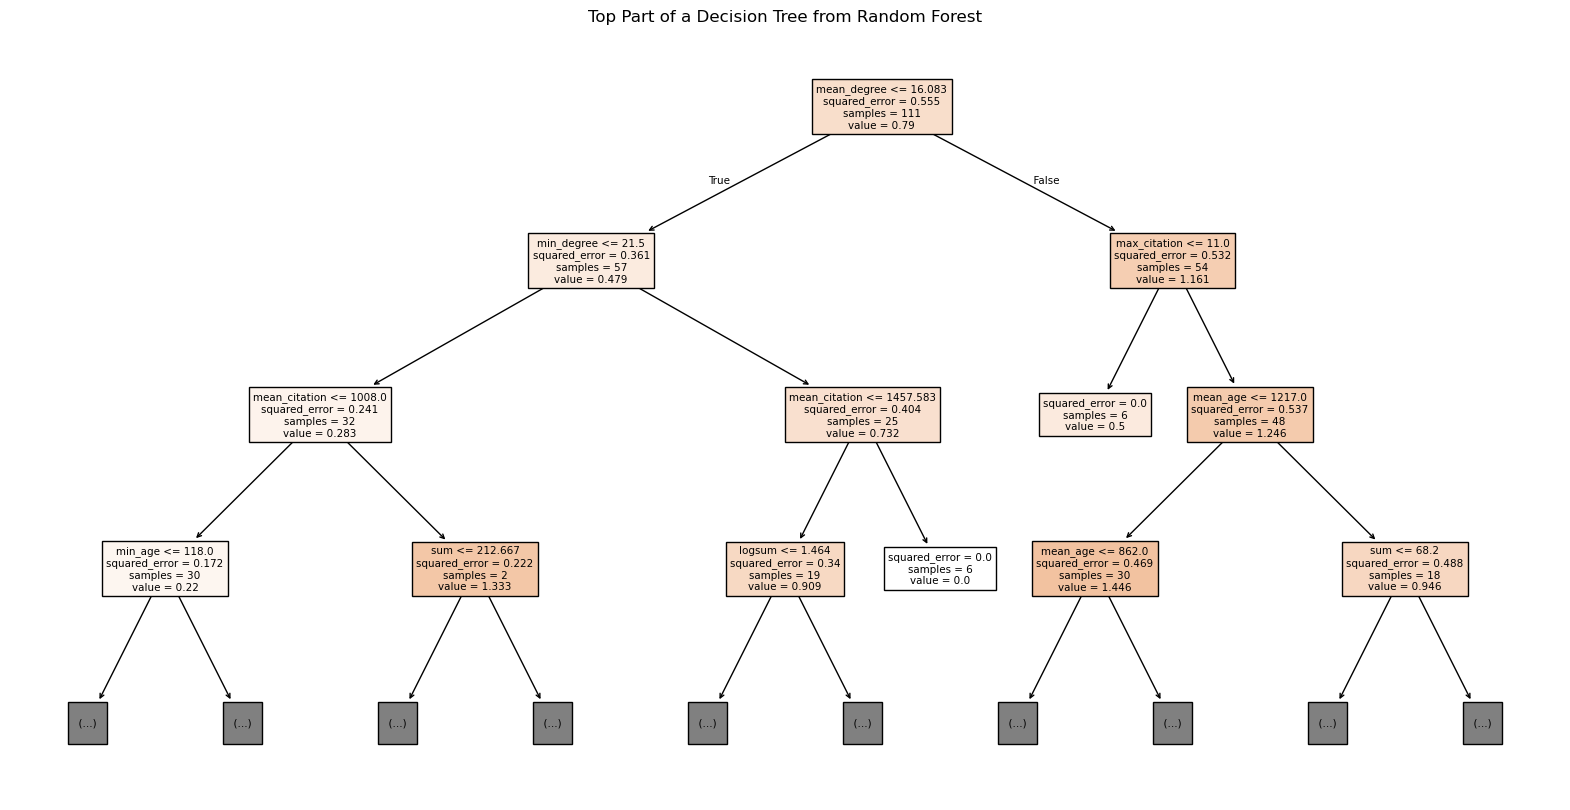

In [28]:
# Random forest

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Checking feature importance
feature_importance = model.feature_importances_
feature_names =['sum', 'logsum', 'connectivity', 'mean_age', 'max_age', 'min_age', 'mean_degree', 'max_degree', 'min_degree', 'mean_citation', 'max_citation', 'min_citation']

plt.figure(figsize=(30, 6))
plt.bar(feature_names, feature_importance, align='center')
plt.xticks(feature_names)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()

# top part of a single decision tree, though it does not say much on its own 
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], max_depth=3, filled=True, feature_names=feature_names)
plt.title('Top Part of a Decision Tree from Random Forest')
plt.show()


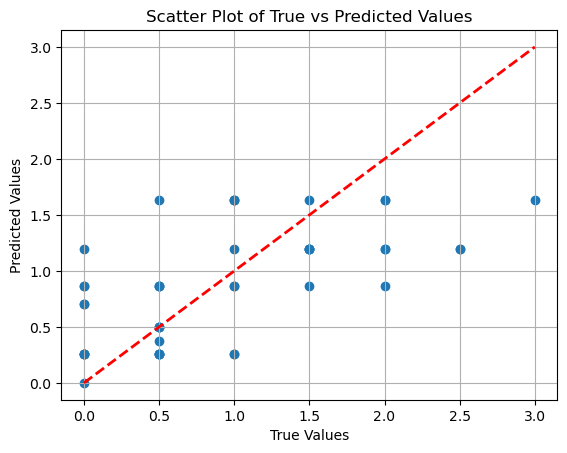

In [29]:
plt.scatter(y_test, y_pred)
# Reference line for perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.grid(True)
plt.show()

# Old approach: matrix of raw edge weights

In [ ]:
"""

Proposed structure

  A B C
A c* 1 3
B 1 c* 2
C 3 2  c*

ABC are tools
numbers are their edge weights - their connections
c* is the number of citations for each tool - connections to themselves

symmetrical: only store half
Self connection contains node information

Problems: 
this format requires all workflows to be of same length or to specify some upper limit. 
This format assumes there can not be repetitions fo tools, two tools could be used alternatingly in a workflow


"""

'\n\nProposed structure\n\n  A B C\nA c* 1 3\nB 1 c* 2\nC 3 2  c*\n\nABC are tools\nnumbers are their edge weights - their connections\nc* is the number of citations for each tool - connections to themselves\n\nsymmetrical: only store half\nSelf connection contains node information\n\nProblems: this format requires all workflows to be of same length or to specify some upper limit. \n\n\n\n'

In [30]:
def convert_to_tuples(list_of_lists):
    """
    Converts a list of lists into a list of tuples.

    :param list_of_lists: List of lists to be converted.
    :return: List of tuples.
    """
    return [tuple(inner_list) for inner_list in list_of_lists]



In [31]:
# checking how many highly rated worklows are defined in the graph
highly_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] >= 2] # this means that at least one of them gave it a two or higher
highly_rated_workflows = [convert_to_tuples(workflow) for workflow in highly_rated_workflows]
notnone_highly_rated_workflows = []

for workflow in highly_rated_workflows:
    tools = {pmid for tup in workflow for pmid in tup} # collect what tools are in the workflow, ignoring Nones
    if not None in tools:
        notnone_highly_rated_workflows.append(workflow)
print(len(notnone_highly_rated_workflows))

40


In [32]:
# The "features" that will be input (make up the matrix)
for edge in notnone_highly_rated_workflows[0]:
    print(edge)
    print(get_graph_edge_weight(graph, edge))
    print(citation_counts[edge[0]], citation_counts[edge[1]])
    print(tool_ages[edge[0]], tool_ages[edge[1]])

('23051804', '23148064')
101.0
1510 718
None 2013 Jan
('23148064', '12403597')
181.0
718 3040
2013 Jan 2002 Oct 15
('12403597', '14632076')
1919.0
3040 2955
2002 Oct 15 None


In [33]:
def nr_tools(workflow, include_none = False):
    tools = set()
    if include_none:
        tools = {pmid for tup in workflow for pmid in tup if pmid is not None}
        return tools 
    else:
        tools = list({pmid for tup in workflow for pmid in tup})
        return tools

In [34]:
def generate_matrix_workflow(workflow, max_nodes, graph, citation_counts, tool_ages):
    matrix = np.zeros((2, max_nodes, max_nodes))

    tools = list({pmid for tup in workflow for pmid in tup})


    for i in range(max_nodes):
        if i >= len(tools) - 1:
            break 
        for j in range(i+1):
            if j >= len(tools) - 1:
                break 
            if i==j:
                
                matrix[0, i, j] = citation_counts[ tools[i] ] # citations
                age = tool_ages[ tools[i] ] or 2000
                matrix[1, i, j] = str(age).split(' ')[0] # ages 
            else: 
                matrix[0, i, j] = get_graph_edge_weight( graph, ( tools[i], tools[j] ))
    
    return matrix


In [35]:
def create_matrix_dataset(workflow_dict, graph, citation_counts, tool_ages):

    labels = np.zeros((len(workflow_dict)))  
    matrix_dataset = list(np.zeros((len(workflow_dict))))

    # largest nr tools in dataset
    workflows = [workflow["pmid_workflow"] for workflow in workflow_dict] # this means that at least one of them gave it a two or higher
    max_nodes = max([ len(nr_tools(workflow)) for workflow in workflows]) # this can not handle emply 
    
    for i, workflow in enumerate(workflow_dict): 
        labels[i] = workflow["ratingAvg"] 
        # Make matrix representation of the workflow (converted to tuples so it works with the metrics)
        matrix_dataset[i] = generate_matrix_workflow( convert_to_tuples(workflow["pmid_workflow"]) , max_nodes, graph, citation_counts, tool_ages)

    return labels, matrix_dataset


In [36]:
def not_none_workflows(workflows, type_ = dict):
    notnone_workflows = []
    
    if type_ == list:
        for workflow in workflows:
            tools = {pmid for tup in workflow for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows
    elif type_ == dict: 
        print("Assuming dictionary follows citation data file format.") # maybe spec what that is 
        for workflow in workflows:
            tools = {pmid for tup in convert_to_tuples(workflow['pmid_workflow']) for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows

In [37]:
workflow_dict = not_none_workflows(rated_workflows)
print(len(workflow_dict))
labels, matrix_dataset = create_matrix_dataset(workflow_dict, graph, citation_counts, tool_ages)

Assuming dictionary follows citation data file format.
217


In [38]:
print(labels[0], matrix_dataset[0])

0.5 [[[1510.    0.    0.    0.    0.    0.]
  [  49. 2955.    0.    0.    0.    0.]
  [ 101.   92.  718.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]

 [[2000.    0.    0.    0.    0.    0.]
  [   0. 2000.    0.    0.    0.    0.]
  [   0.    0. 2013.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]]


Here the publication dates should definitely be changed into ages instead - and perhaps 100 for not defined ages? 

We want an as easily interpretable ML model as possible, so startign with decision trees 

In [39]:
X = [matrix.flatten() for matrix in matrix_dataset]
y = labels

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # obs this should be stratified

Mean Squared Error: 0.55


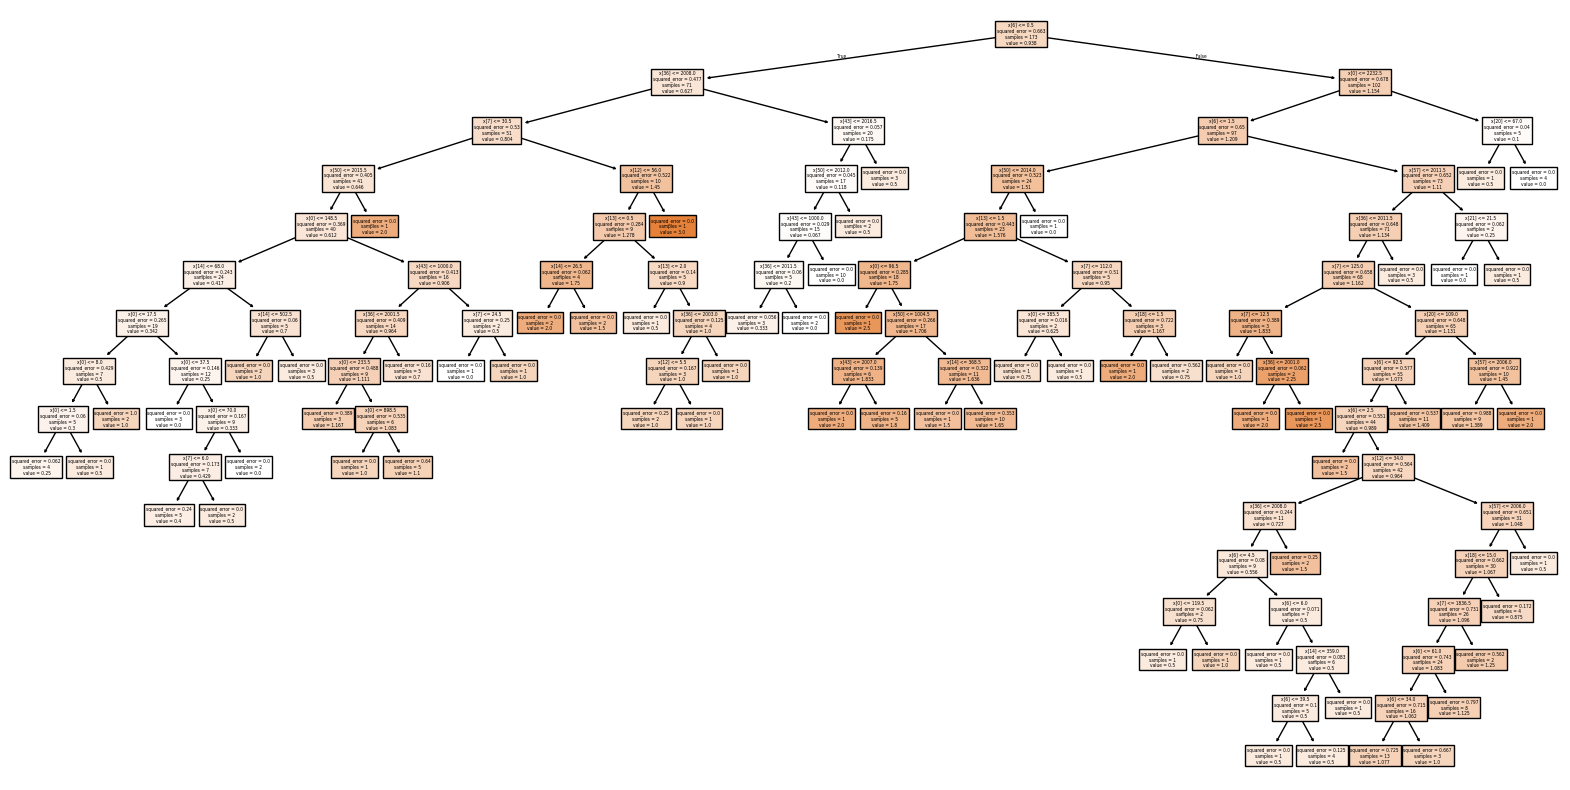

Spearman correlation coefficient between original and predicted ratings: 0.49


In [40]:
# Descision tree model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


plt.figure(figsize=(20, 10))
tree.plot_tree(model, filled=True)
plt.show()

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Mean Squared Error: 0.51


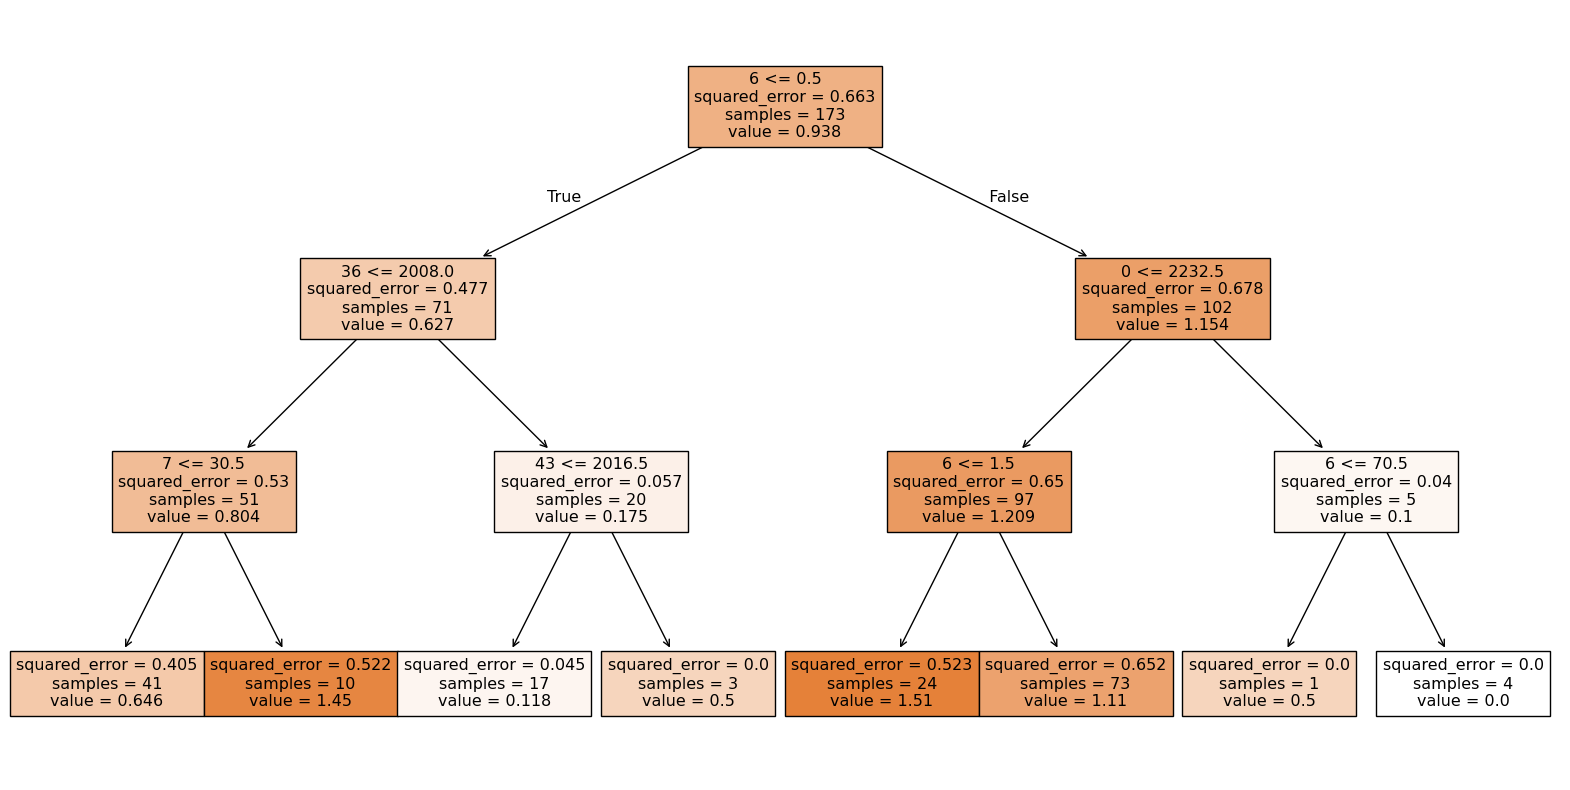

Spearman correlation coefficient between original and predicted ratings: 0.41


In [45]:
# Making a smaller one - easier to understand 
y_pred = model.predict(X_test)

feature_names = np.arange(len(X_test[0]))  # feature names are not available but could add?

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


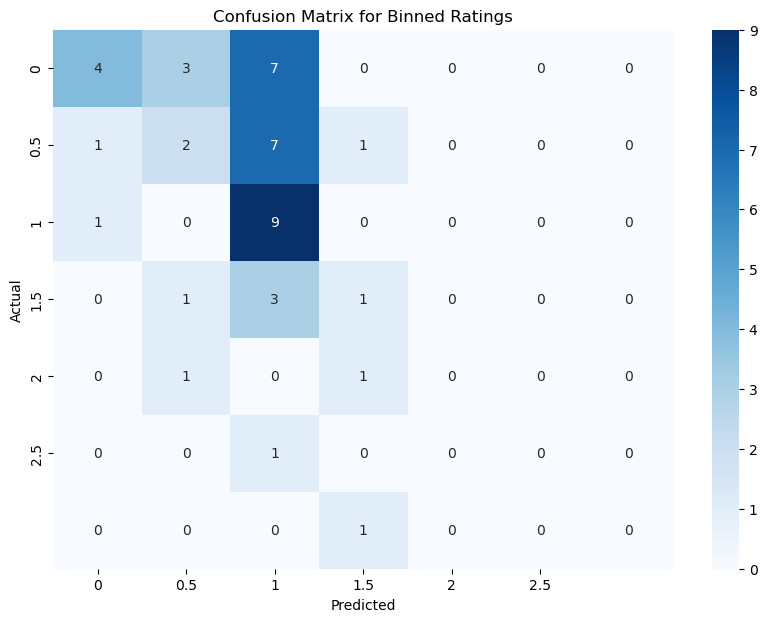

In [46]:
# confusion matrix

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3]
y_test_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred, bins) - 1

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=bins[:-1], yticklabels=bins[:-1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Binned Ratings')
plt.show()

Yeah need to do this stratified, we have no higher rated ones

In [47]:
correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Spearman correlation coefficient between original and predicted ratings: 0.41


In [48]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    correlation, _ = spearmanr(y_test, y_pred)
    return mse, correlation

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Support Vector Regressor": SVR()
}

results = {}
for name, model in models.items():
    mse, correlation = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {
        "Mean Squared Error": mse,
        "Pearson Correlation": correlation
    }

for name, metrics in results.items():
    print(f"{name}:\n - Mean Squared Error: {metrics['Mean Squared Error']:.2f}\n - Spearman Correlation: {metrics['Pearson Correlation']:.2f}\n")


Linear Regression:
 - Mean Squared Error: 1.04
 - Spearman Correlation: 0.36

Random Forest Regressor:
 - Mean Squared Error: 0.52
 - Spearman Correlation: 0.47

Support Vector Regressor:
 - Mean Squared Error: 0.50
 - Spearman Correlation: 0.35



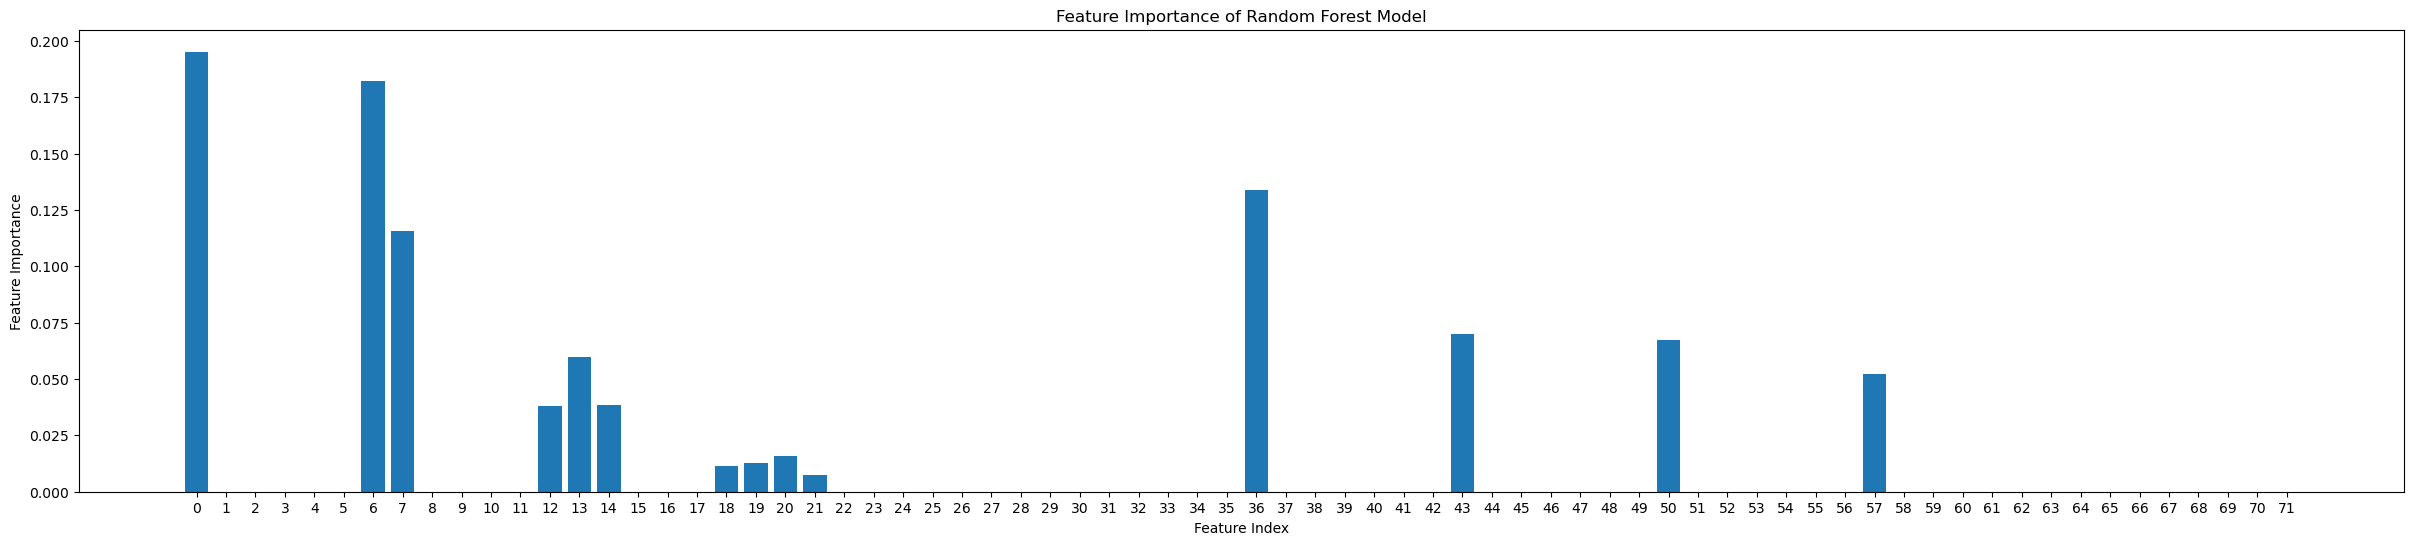

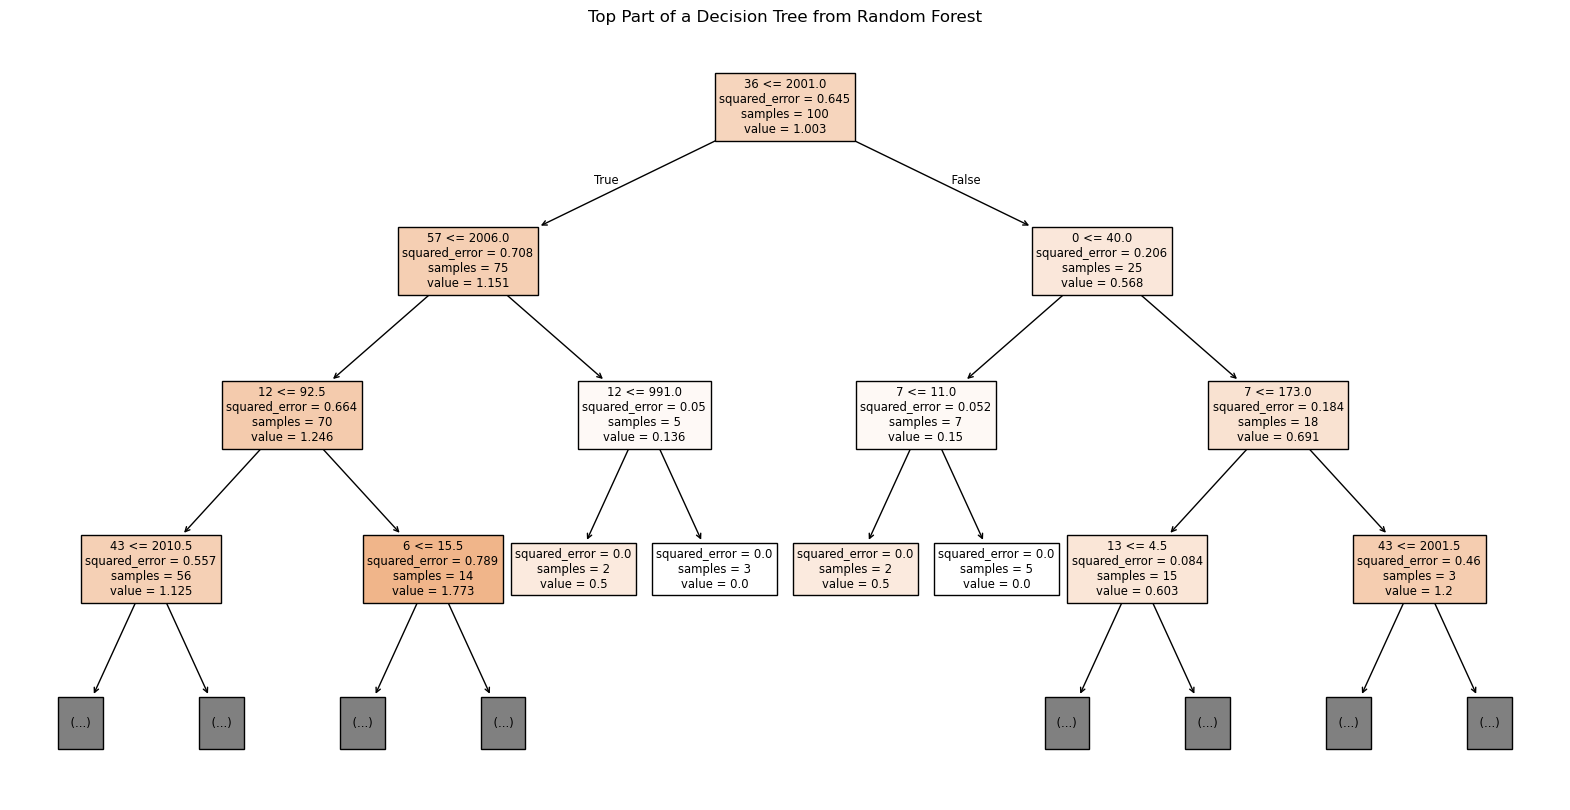

In [49]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
feature_names = np.arange(len(feature_importance))  # feature names are not available
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

plt.figure(figsize=(30, 6))
plt.bar(sorted_feature_names, sorted_feature_importance, align='center')
plt.xticks(sorted_feature_names)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()

# top part of a single decision tree
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], max_depth=3, filled=True, feature_names=feature_names)
plt.title('Top Part of a Decision Tree from Random Forest')
plt.show()


# Future 

Can continue by:

testing of the APE dataset, and on the broken wf dataset - want it to be good for all datasets - combine datasets or what to do? give different ratings/weightd.
Create a more broken dataset? step by step breaking it more. 

choosing to keep different information about the workflows, and changing how they are represented - not flattening for ex? 

other values, like medains, metric scores etc and see if it is used? 

what should it fulfill? have good correlation with rated? detect good bad workflows/ broken edges? 



should all be as important? 
combining different metrics. one good at id bad workflows for ex